In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import xgboost as xgb
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

##### Задание 1: Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;

In [2]:
train = pd.read_csv("data/assignment1/train.csv")
test = pd.read_csv("data/assignment1/test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


In [3]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [4]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [25]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

In [26]:
categorical_features = train.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.head(n=2)

Categorical Feature Count 1


,ID_code
0,train_0
1,train_1


In [8]:
train.isnull().values.any()

False

In [9]:
test.isnull().values.any()

False

##### ORSERVATION: 
* 200000 rows in the test and train sets are a good amount of data to be used to predict the target. 
* Target is between 0 and 1 which means we are going to work on clasification problem. 
* All features have similar naming which is not very descriptive. They are also numeric, except ID_Code. 
* It seems like ID_Code doesn't hond any important information. So, it can be droped. 
* We don't have any missing data. And I didn't see any outliers yet. It's a big starange

##### Задание 2: Сделать базовый анализ целевой переменной, сделать выводы;

In [10]:
train['target'].unique()

array([0, 1])

In [11]:
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

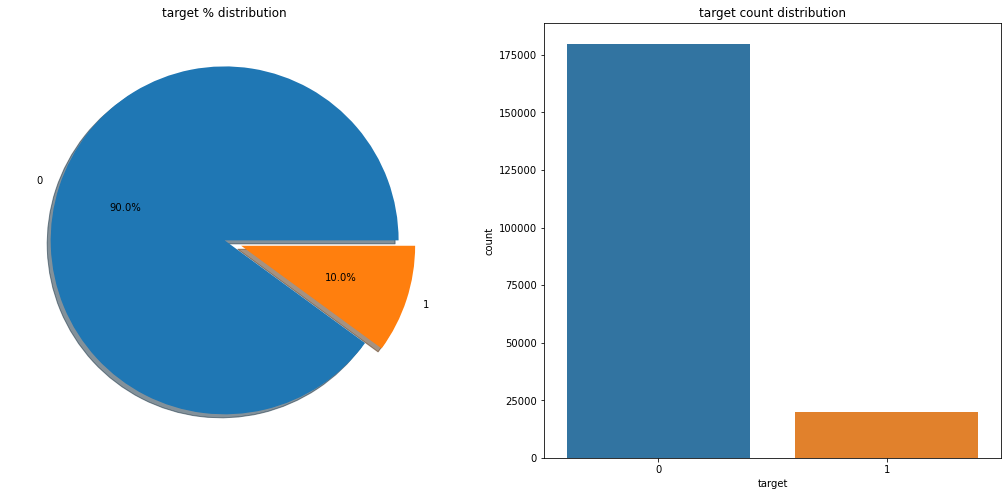

In [12]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('target % distribution')
ax[0].set_ylabel('')
sns.countplot(train['target'])
ax[1].set_title('target count distribution')
plt.show()

##### OBSERVATION: 
* We have only two values in the target: 0 and 1. We are going to work on the clasification problem. 
* We have a disbalance in the data set

##### Задание 3: Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

In [13]:
selected_features = ["var_0", "var_1", "var_2", "var_5", "var_9", "var_10", "var_13", "var_20", "var_26", "var_40", "var_55", "var_80", "var_106", "var_109", "var_139", "var_175", "var_184", "var_196"]

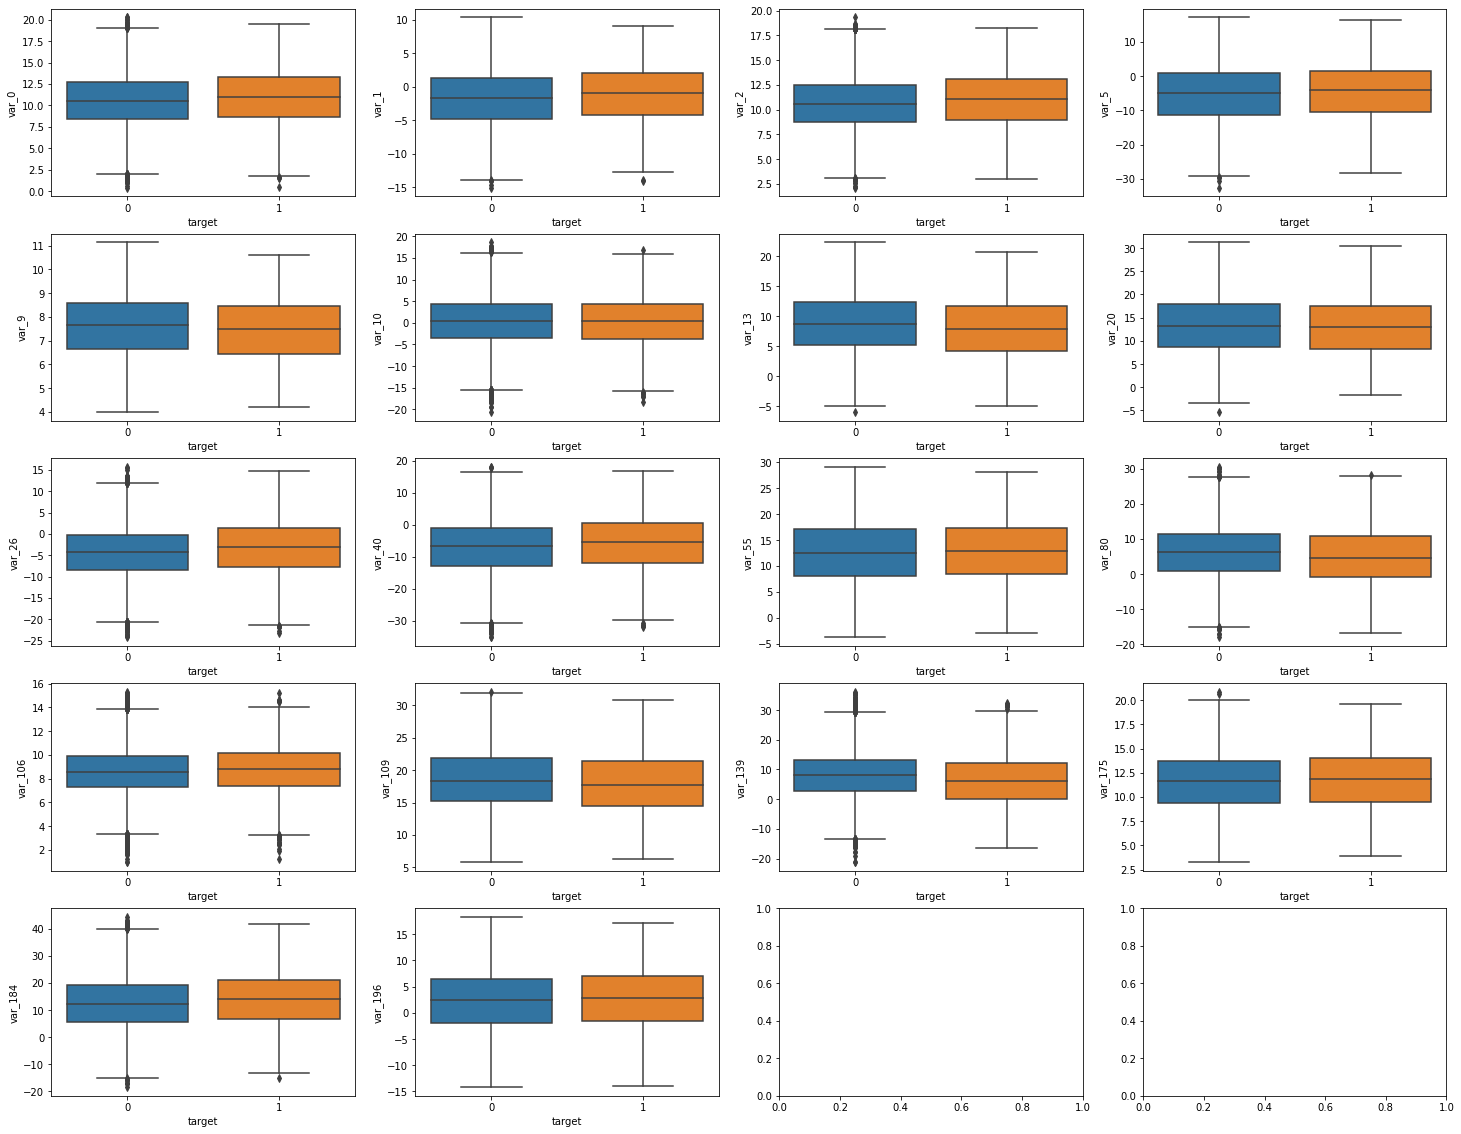

In [14]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))

for idx, feat in  enumerate(selected_features):
    sns.boxplot(x='target', y=feat, data=train, ax=axes[idx // 4, idx % 4])
    axes[idx // 4, idx % 4].set_xlabel('target')
    axes[idx // 4, idx % 4].set_ylabel(feat)

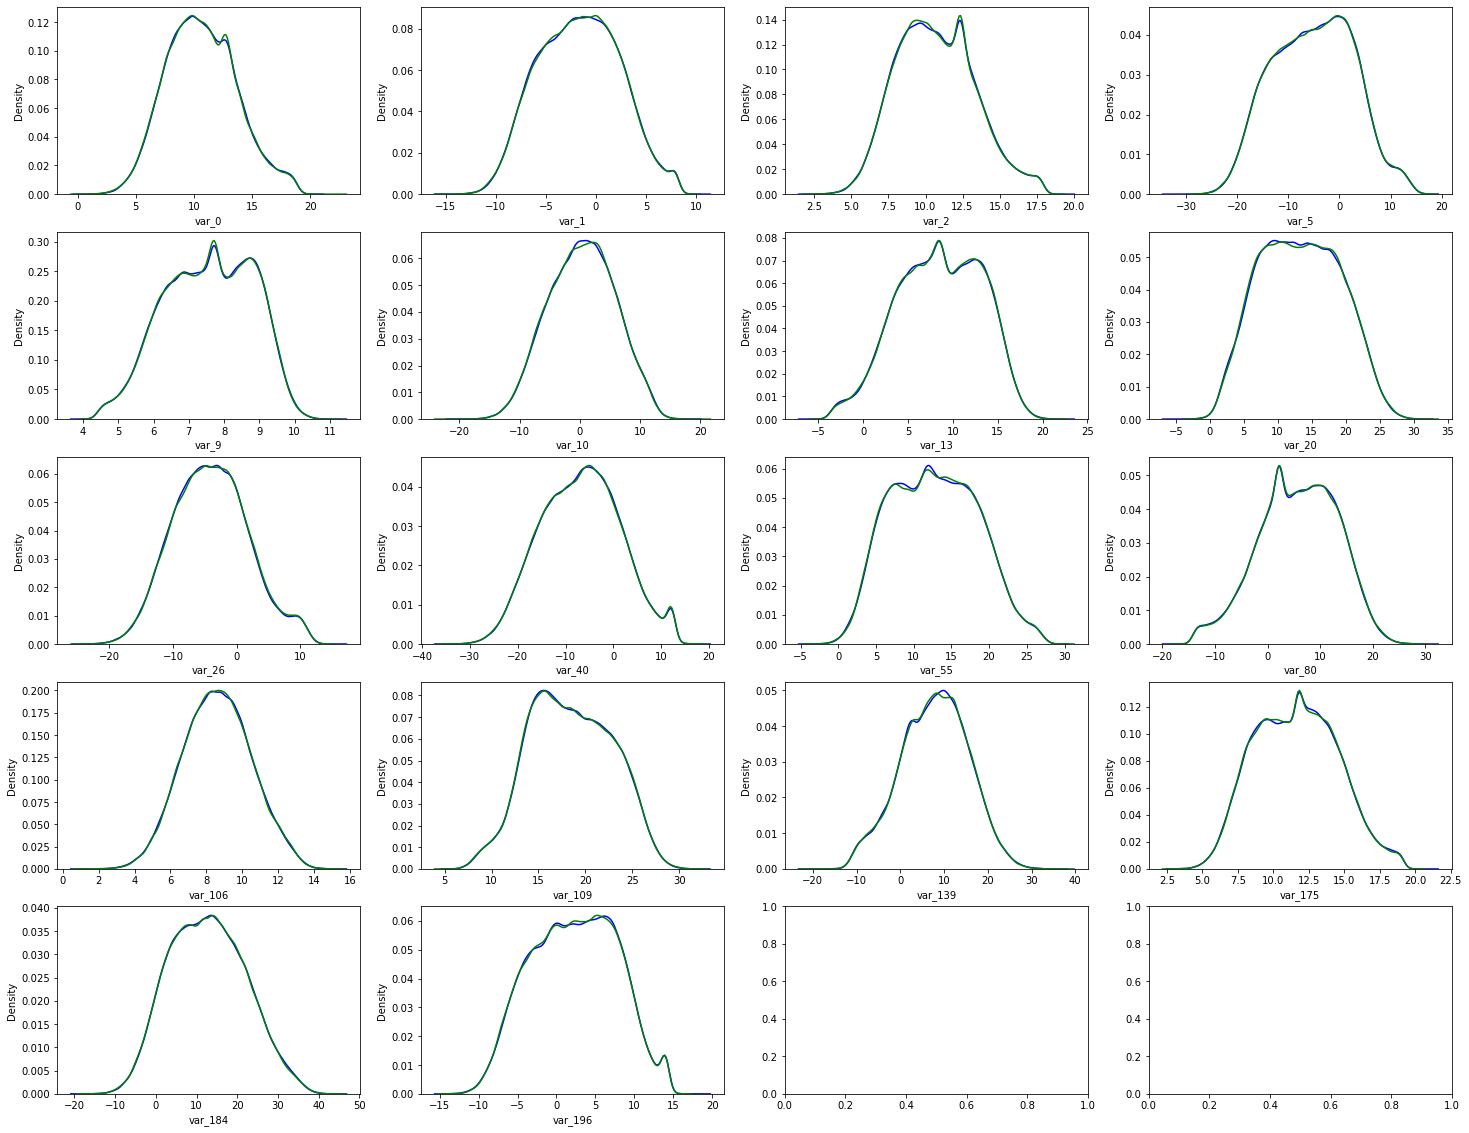

In [15]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))

for num, feature in enumerate(selected_features):
    train_data, test_data = train[feature].copy(), test[feature].copy()
    sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
    sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")

##### OBSERVATION: 
* Most of the features are having more less normal distribution. 
* Data on the train and test sets are similar. We are probably going to have a stable prediction on train and test data
* For some fatures like var0, var2, var139, var184, the boxplot graph shows a difference in target disptibution. They might not be as important and information for our prediction

##### Задание 5: Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

In [16]:
selected_features = train[["target", "var_0", "var_1", "var_2", "var_5", "var_9", "var_10", "var_13", "var_20", "var_26", "var_40", "var_55", "var_80", "var_106", "var_109", "var_139", "var_175", "var_184", "var_196"]]

In [17]:
correlation = selected_features.corr()
corr_with_target = correlation["target"].sort_values(ascending = False)
corr_with_target

target     1.000000
var_26     0.062422
var_2      0.055870
var_0      0.052390
var_1      0.050343
var_40     0.049530
var_184    0.048315
var_106    0.032947
var_5      0.030979
var_196    0.023608
var_175    0.021692
var_55     0.017176
var_10    -0.002213
var_20    -0.018329
var_9     -0.042805
var_109   -0.049926
var_13    -0.055156
var_80    -0.057609
var_139   -0.074080
Name: target, dtype: float64

<AxesSubplot:title={'center':'Correlation of Selected Numeric Features with Target'}>

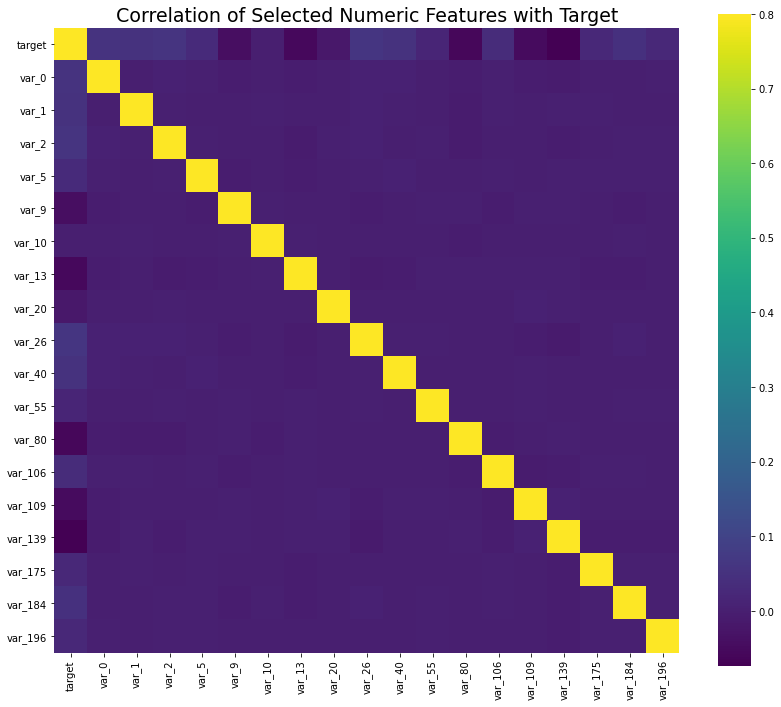

In [18]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Selected Numeric Features with Target", y=1, size=19)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

Text(0, 0.5, 'Density')

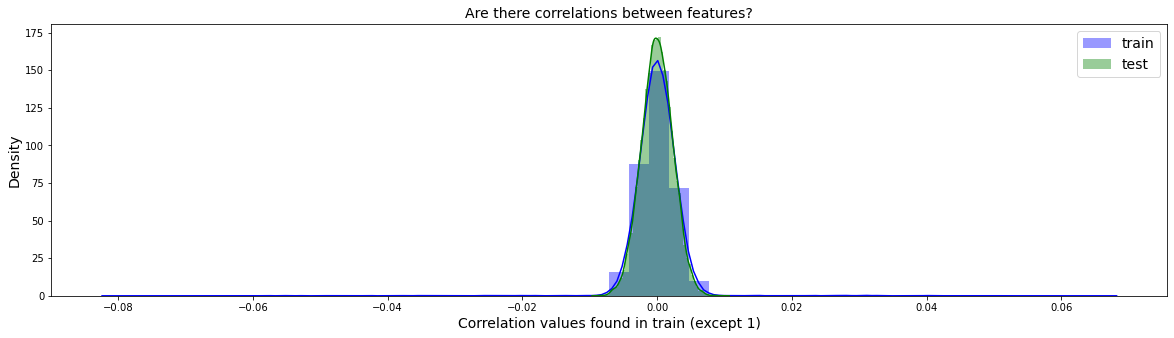

In [19]:
train_correlations = train.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

##### OBSERVATION:
* I don't see a strong correlation between features that exceed .2. It seems like our data set doesn't have a strong linear relashioship between features and target

In [20]:
correlation = numerical_features.corr()
corr_with_target = correlation["target"].sort_values(ascending = False)
corr_with_target

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
             ...   
var_76    -0.061917
var_146   -0.063644
var_12    -0.069489
var_139   -0.074080
var_81    -0.080917
Name: target, Length: 201, dtype: float64

##### Задание 6: Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [35]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(numerical_features.drop("target", axis=1), train["target"])

CPU times: user 6min 59s, sys: 2.51 s, total: 7min 1s
Wall time: 3min 42s


RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=2, random_state=27)

Text(0.5, 1.0, 'What are the top important features to start with?')

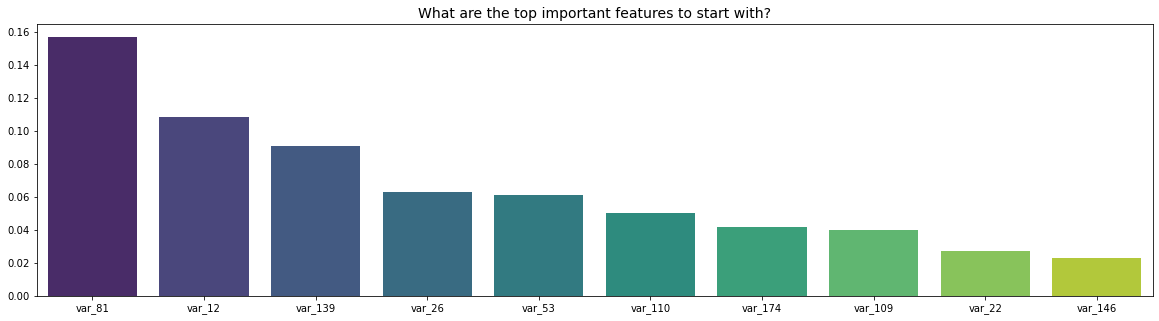

In [36]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = numerical_features.drop("target", axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

##### Задание 7 (опция): Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

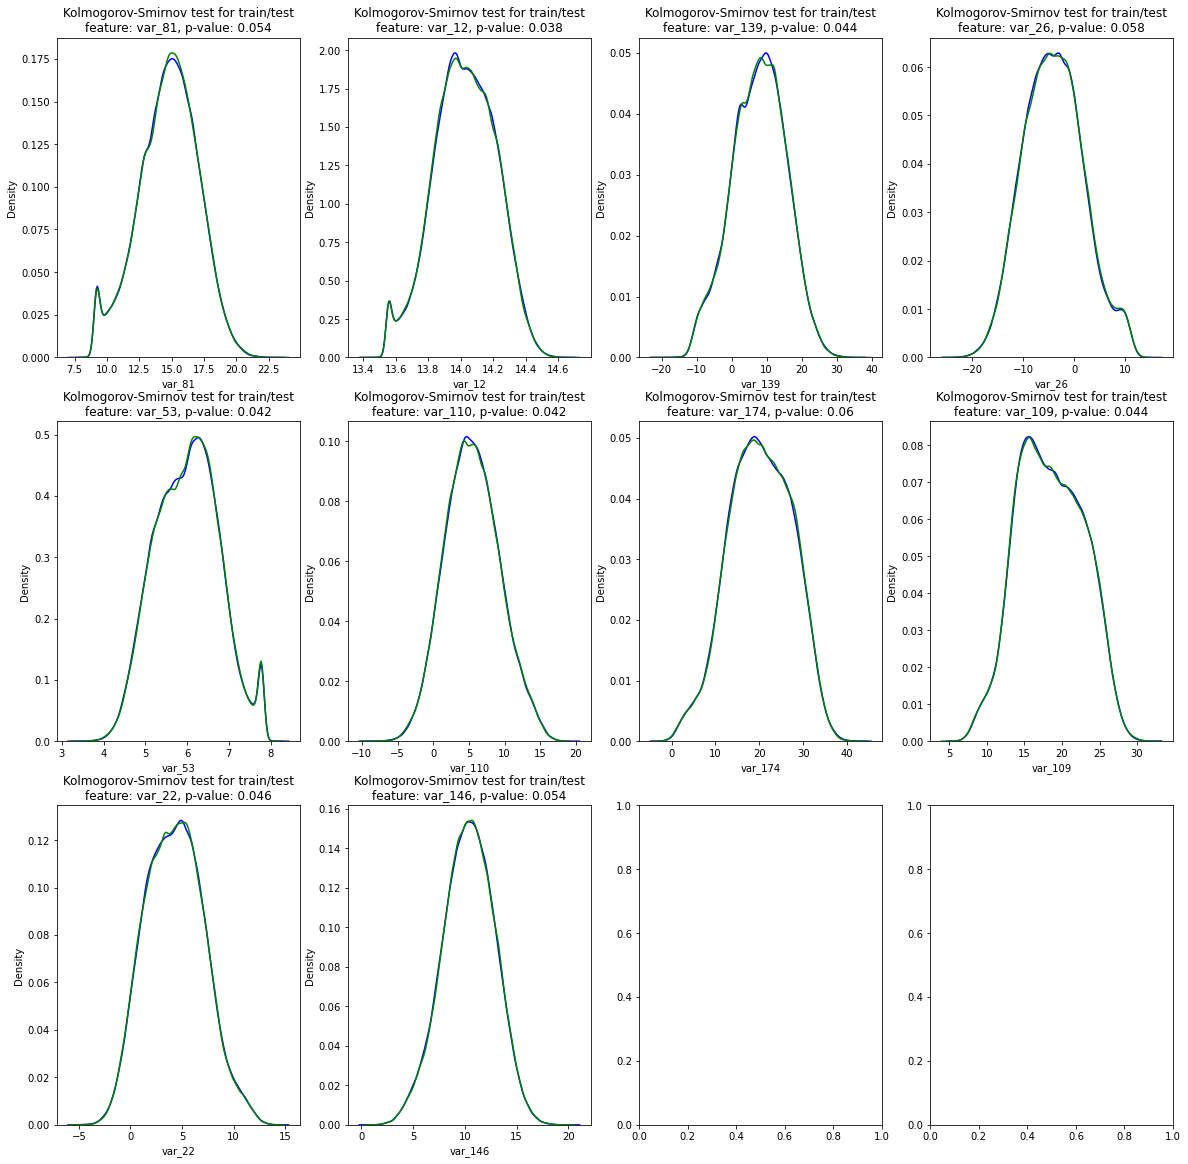

In [38]:
statistics_array = []
fig, axes = plt.subplots(3, 4, figsize=(20, 20))

for num, feature in enumerate(feature_names[idx]):
    statistic, pvalue = ks_2samp(
        train[feature].sample(500), test[feature].sample(500)
    )
    statistics_array.append(statistic)

    sns.kdeplot(train[feature], ax=axes[num//4, num%4], color="Blue", label="Train")
    sns.kdeplot(test[feature], ax=axes[num//4, num%4], color="Green", label="Test")

    axes[num//4, num%4].set_title(
        (f"Kolmogorov-Smirnov test for train/test\n"
        f"feature: {feature}, p-value: {round(statistic, 3)}")
    )

OBSERVATION:
* Not every feature has a p-value more than 0.05 which means that the distribution between test and train set might be too different to have a stable prediction